# Group 005 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [2]:
# import zipfile
# with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
4510304,5750000,2020-10-04,12:38:54,55.914757,37.798812,81,2,3,25,1,43.5,10.0,1
2103373,2785000,2019-06-30,14:13:41,56.789925,60.617345,6171,0,7,16,2,59.5,10.0,11
855430,4056840,2018-12-31,10:19:14,59.897817,30.459392,2661,2,24,24,1,35.4,8.3,11
3639805,2400000,2020-04-22,07:03:58,45.112995,38.928099,2843,2,5,7,1,39.0,9.0,1
4633658,2340059,2020-10-30,11:48:38,56.877814,60.524459,6171,0,17,25,1,31.0,7.4,11


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [41]:
MOSCOW_CODE = 81
MAX_NUM_SAMPLES = 100000
SEED = 69

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]
# moscow_df['price'] = moscow_df['price'] * 1e-4

# cap number of elements
moscow_df = moscow_df.sample(MAX_NUM_SAMPLES, random_state=SEED)

In [42]:
moscow_df.isnull().values.any()

False

In [43]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
4691836,7068200,2020,panel,4,25,2,59.9,20.9,new
359753,4400000,2018,brick,7,9,1,34.1,6.0,preowned
4471776,3835940,2020,monolithic,9,17,2,53.8,10.4,new
1466305,1900000,2019,brick,1,9,1,31.7,6.0,preowned
300514,5900000,2018,panel,12,13,3,65.0,8.0,preowned


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [44]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.756386e+06,2019.310120,7.053700,12.752370,1.776320,51.592710,10.362995
std,2.964111e+06,0.880621,5.692804,7.411351,0.862656,21.748209,6.834285
min,1.500000e+03,2018.000000,1.000000,1.000000,0.000000,2.400000,0.120000
25%,3.000000e+06,2019.000000,3.000000,5.000000,1.000000,38.000000,7.000000
50%,4.300000e+06,2019.000000,5.000000,12.000000,2.000000,46.000000,9.700000
75%,5.950000e+06,2020.000000,10.000000,17.000000,2.000000,61.900000,12.000000
max,2.977413e+08,2021.000000,36.000000,38.000000,9.000000,997.000000,1131.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

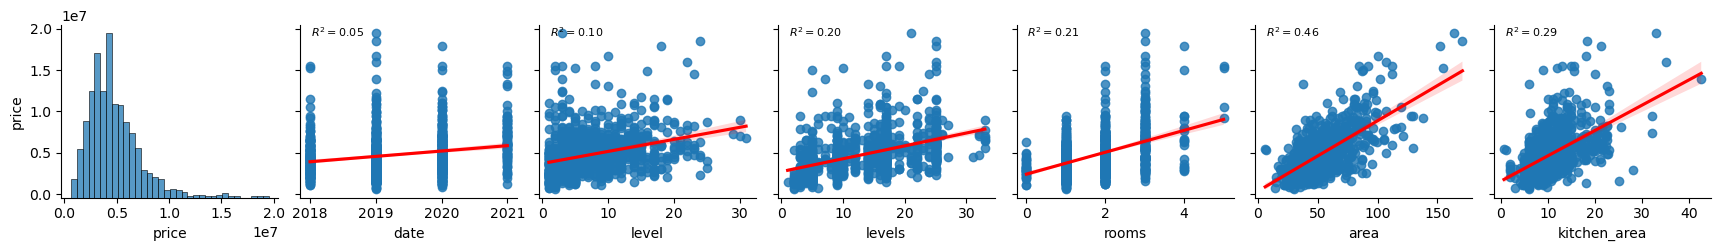

In [45]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like te might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

<Axes: >

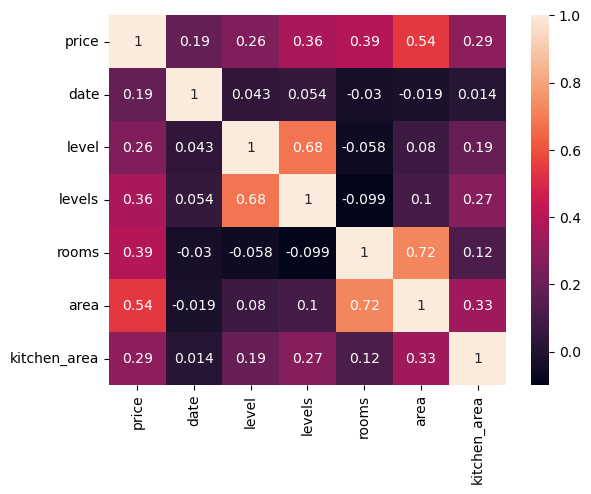

In [46]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [47]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

70000 train samples; 30000 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [48]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
116014,2018,4,12,1,40.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4185698,2020,2,25,3,78.9,11.4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1444513,2019,3,5,2,45.4,5.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
853762,2018,11,16,2,57.4,18.6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
914184,2019,4,5,1,28.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [49]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
461511,-1.486208,-0.716377,-1.052022,1.415813,0.778293,-0.422331,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
685101,-1.486208,-0.364642,-1.052022,-0.900040,-0.941634,-0.581066,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1710236,-0.350955,-0.892245,-1.456962,0.257887,1.750029,1.270849,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4102857,0.784297,1.394036,1.242640,0.257887,0.249085,-0.157771,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2655205,-0.350955,1.569904,0.702720,-0.900040,-0.622284,-0.051948,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [50]:
# MAX_EPOCHS = 1000000

### Linear Regression

Note that SckiKit doesn't offer MAE loss for its `LinearRegression` implementation. However, `linear_model.SGDRegressor` can be made to use an MAE loss by using `epsilon_insensitive` loss and setting its $\epsilon$ hyperparam to $0$.

Note that this does mean we will be using SGD for descent, so our model will take more steps to converge and loss won't strcitly decrease, but in our case using SGD will actually be helpful since our dataset is relatively large, so each epoch will be much faster.

In [51]:
# from sklearn.linear_model import SGDRegressor

# linreg_mae_model = SGDRegressor(loss='epsilon_insensitive', epsilon=0, max_iter=MAX_EPOCHS, verbose=1)

In [52]:
# linreg_mae_model.fit(X_train_scaled, y_train)

In [53]:
# import pickle

# filename = 'trained_model.sav'
# pickle.dump(linreg_mae_model, open(filename, 'wb'))

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Pandas &rarr; CuDF for Rapids

In [55]:
import cudf
import cupy as cp

In [56]:
def to_cudf(pd_df):
    data = dict()

    for col in pd_df.columns:
        data[col] = pd_df[col].to_numpy()

    cudf_df = cudf.DataFrame(data)

    return cudf_df

In [57]:
X_train_cudf = to_cudf(X_train)
y_train_cudf = cudf.Series(y_train.to_numpy())

X_test_cudf = to_cudf(X_test)
y_test_cudf = cudf.Series(y_test.to_numpy())

### Random Forests for Regression

In [59]:
import cuml
from cuml.ensemble import RandomForestRegressor

from cuml.common.device_selection import using_device_type, set_global_device_type
from cuml.ensemble import RandomForestRegressor as curfr


set_global_device_type('GPU')
rf_cuml = curfr(n_estimators=100, accuracy_metric='mean_ae', verbose=True)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
hparam_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [63]:
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(estimator=rf_cuml, param_distributions=hparam_grid, n_iter=100, cv=5, verbose=2, random_state=SEED)

rf_grid.fit(X_train_cudf, y_train_cudf)

/home/arths/.conda/envs/cogs118a-g5/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomForestRegressor()

In [64]:
print('train stats')
rf_train_score = rf_grid.score(X_train_cudf, y_train_cudf)

print('train stats')
rf_test_score = rf_grid.score(X_train_cudf, y_train_cudf)

[D] [01:49:44.266737] /opt/conda/conda-bld/work/cpp/src/randomforest/randomforest.cu:103 Mean Absolute Error: 680291.225996
[D] [01:49:44.266822] /opt/conda/conda-bld/work/cpp/src/randomforest/randomforest.cu:104 Mean Squared Error: 1215891455298.665527
[D] [01:49:44.266827] /opt/conda/conda-bld/work/cpp/src/randomforest/randomforest.cu:105 Median Absolute Error: 506327.352038
680291.2259962966


In [31]:
# import pickle

# # save
# with open('model.pkl','wb') as f:
#     pickle.dump(rf_model,f)

# # # load
# # with open('model.pkl', 'rb') as f:
# #     rf_model = pickle.load(f)